<a href="https://colab.research.google.com/github/ShaominXu/Image-and-video-processing-labs/blob/main/Pyramid%20Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CA03
NetID: sx2311

Name: Shaomin Xu

## Problem 1

In [ ]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### (a) Functions `gaussian_pyramid`

In [ ]:
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels-1):
        image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
        pyramid.append(image)
    return pyramid


### Functions `laplacian_pyramid`

In [ ]:
def laplacian_pyramid(image, levels):
    pyramid = gaussian_pyramid(image, levels)
    laplacian_pyramid = []
    for i in range(levels-1):
        higher_res = cv2.resize(pyramid[i + 1], (pyramid[i].shape[1], pyramid[i].shape[0]), interpolation=cv2.INTER_CUBIC)
        laplacian = cv2.subtract(pyramid[i], higher_res)
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(pyramid[-1])
    return laplacian_pyramid

### (b) Function `reconstruct_laplacian`

In [ ]:
def reconstruct_laplacian(laplacian_pyramid):
    levels = len(laplacian_pyramid)
    reconstructed_image = laplacian_pyramid[-1]  # Start with the finest (J-th) level
    if levels > 1:
      for i in range(levels - 2, -1, -1):
          higher_res = cv2.resize(reconstructed_image, (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]), interpolation=cv2.INTER_CUBIC)
          reconstructed_image = cv2.add(higher_res, laplacian_pyramid[i])
    return reconstructed_image

### Display the Gaussian and Laplacian pyramid images for J = 3

Gaussian pyramid images


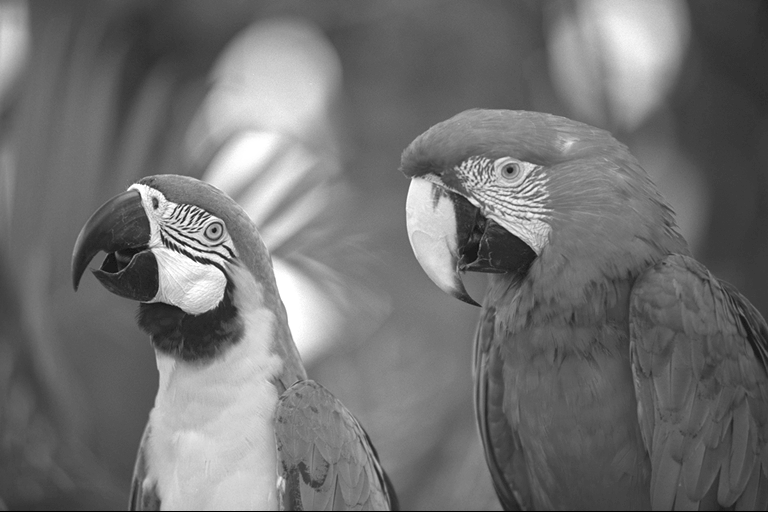

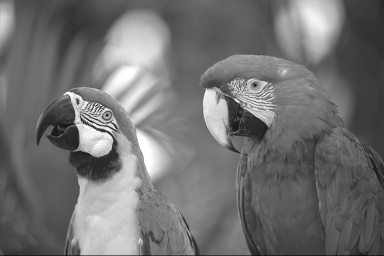

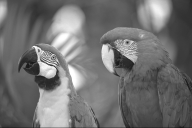

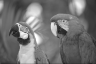

Laplacian pyramid images


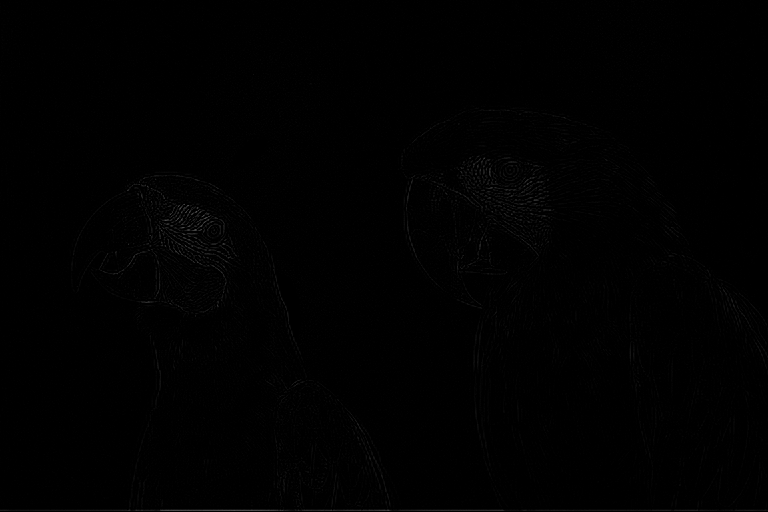

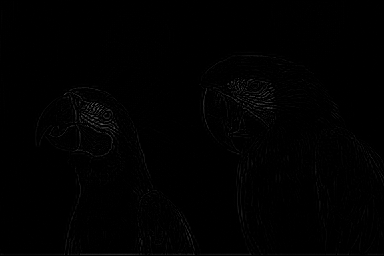

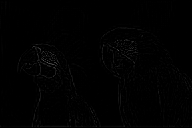

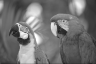

Reconstructed image


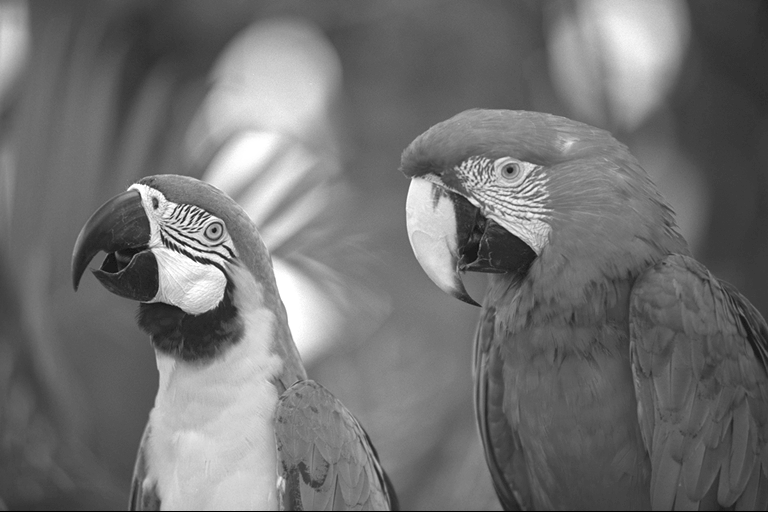

In [ ]:
from google.colab.patches import cv2_imshow

def display_pyramids(image, levels):
    gaussian_pyr = gaussian_pyramid(image, levels)
    laplacian_pyr = laplacian_pyramid(image, levels)

    # Display Gaussian pyramid images
    print("Gaussian pyramid images")
    for i, img in enumerate(gaussian_pyr):
        cv2_imshow(img)

    # Display Laplacian pyramid images
    print("Laplacian pyramid images")
    for i, img in enumerate(laplacian_pyr):
        cv2_imshow(img)


# Load a image
test_image = cv2.imread('color image.png', cv2.IMREAD_GRAYSCALE).astype(float)

# Define the number of pyramid levels (L)
J = 3
L = J + 1
# Display Gaussian and Laplacian pyramid images for the test image
display_pyramids(test_image, L)

# Reconstruct the original image from the Laplacian pyramid
reconstructed_image = reconstruct_laplacian(laplacian_pyramid(test_image, L))

# Display the reconstructed image
print("Reconstructed image")
cv2_imshow(reconstructed_image)


### (c) Function ` quantize_pyramid`

In [ ]:
def quantize_pyramid(laplacian_pyramid, q):
    quantized_pyramid = []

    for laplacian in laplacian_pyramid:
        if laplacian[0, 0] == 128:  # Assuming it's a Gaussian image
            mu = 128
        else:
            mu = 0  # It's a Laplacian image

        quantized_laplacian = q * np.floor((laplacian - mu) / q + 0.5) + mu
        quantized_pyramid.append(quantized_laplacian)

    return quantized_pyramid



### (d) Plot PSNR on the y-axis and NNZ on the x-axis

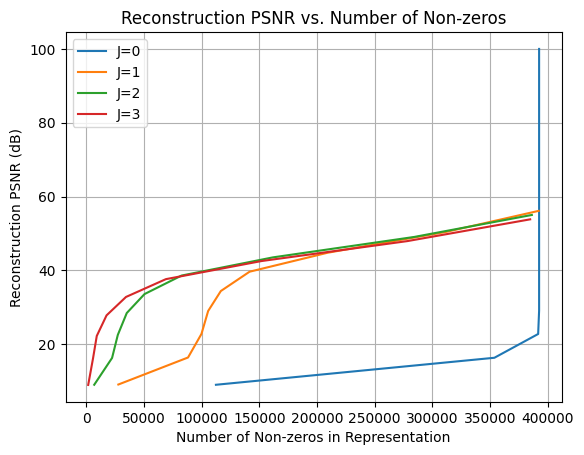

In [ ]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
      psnr = 100
    else:
      psnr = 10 * np.log10((255**2) / mse)
    return psnr

def count_non_zeros(image):
    return np.count_nonzero(image)

# Load the original image
original_image = cv2.imread('color image.png', cv2.IMREAD_GRAYSCALE).astype(float)

# Define the range of pyramid levels J (0, 1, 2, 3)
pyramid_levels = range(4)

# Define the range of quantization steps q (2^n for n in [0, 1, ..., 8])
quantization_steps = [2**n for n in range(9)]

psnr_values = {level: [] for level in pyramid_levels}
non_zeros = {level: [] for level in pyramid_levels}
reconstructed_images = {level: [] for level in pyramid_levels}

for level in pyramid_levels:
    laplacian_pyr = laplacian_pyramid(original_image, level+1)

    for q in quantization_steps:
        quantized_pyr = quantize_pyramid(laplacian_pyr, q)
        reconstructed_image = reconstruct_laplacian(quantized_pyr)

        psnr = calculate_psnr(original_image, reconstructed_image)
        non_zero_count = sum([count_non_zeros(lap) for lap in quantized_pyr])

        psnr_values[level].append(psnr)
        non_zeros[level].append(non_zero_count)
        reconstructed_images[level].append(reconstructed_image)

# Plot PSNR vs. Number of Non-zeros for each pyramid level
for level in pyramid_levels:
    plt.plot(non_zeros[level], psnr_values[level], label=f'J={level}')

plt.xlabel('Number of Non-zeros in Representation')
plt.ylabel('Reconstruction PSNR (dB)')
plt.legend()
plt.grid(True)
plt.title('Reconstruction PSNR vs. Number of Non-zeros')
plt.show()


Increasing pyramid depth generally leads to higher representation efficiency for a desired reconstruction PSNR.

It's expected. This is because the pyramid captures more detail, and you can retain more image information at lower quantization steps (q). Deeper pyramids are particularly useful when you want high-quality reconstructions with minimal loss of detail.

### (e)

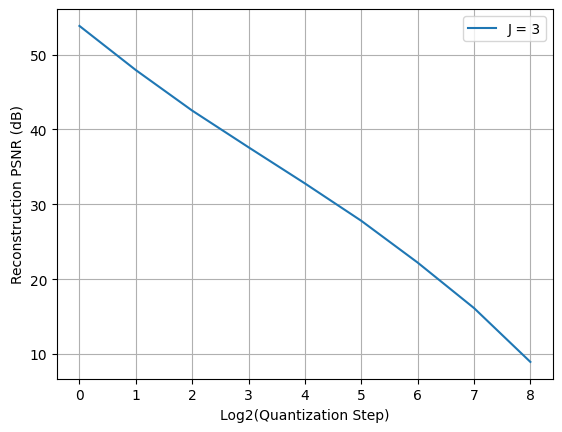

In [ ]:
level = 3
plt.plot(np.log2(quantization_steps), psnr_values[level], label = f"J = {level}")

plt.xlabel('Log2(Quantization Step)')
plt.ylabel('Reconstruction PSNR (dB)')
plt.legend()
plt.grid(True)
plt.show()

For J = 3, the quantization level is unnoticeable when $q = 2^0$ because PSNR gets maximum at this point.

Reconstructed Image


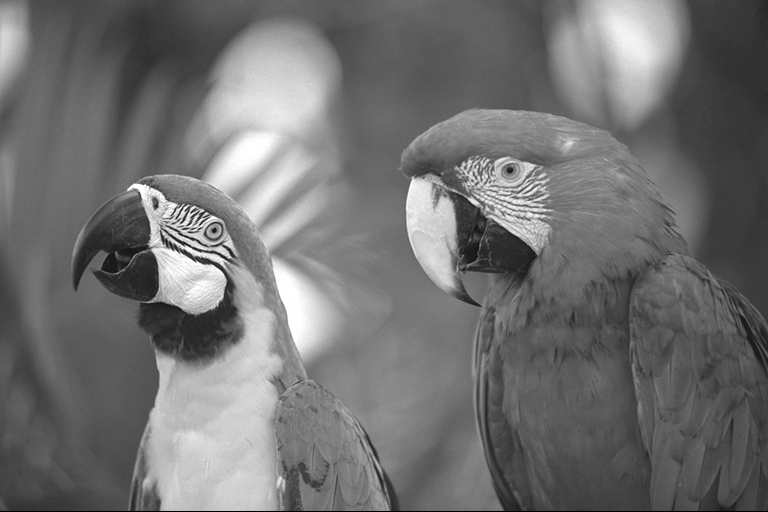

The number of non-zeros of reconstructed image when q = 2^0:
393216
The number of non-zeros of the pyramid:
384707
The maximum of PSNR at the point:
53.81833228687658
The number of non-zeros of original image:
392448


In [ ]:
print("Reconstructed Image")
cv2_imshow(reconstructed_images[3][0])
# the number of non-zeros of reconstructed image
non_zeros_reconstructed_image = count_non_zeros(reconstructed_images[3][0])
# the number of non-zeros of the pyramid
non_zeros_py = non_zeros[3][0]
# the maximum of PSNR at the point
psnr_val = psnr_values[3][0]
# the number of non-zeros of original image
non_zeros_original_image = count_non_zeros(original_image)

print("The number of non-zeros of reconstructed image when q = 2^0:")
print(non_zeros_reconstructed_image)
print("The number of non-zeros of the pyramid:")
print(non_zeros_py)
print("The maximum of PSNR at the point:")
print(psnr_val)
print("The number of non-zeros of original image:")
print(non_zeros_original_image)

The number of non-zeros of the reconstructed image is even more than the number of non-zeros of original image.

The number of non-zeros of the pyramid is about a half of the number of non-zeros of original image.